# BMEB W4020: Circuits in the Brain 2025 Fall Project \#2

*Author:* Shashwat Shukla <shashwat.shukla@columbia.edu>

Based on past work by Tingkai Liu and Cong Han

*Copyright 2025* Bionet Lab

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All). 
Make sure you fill up your name and collaborators below:

### Your names and UNI here

In this project, you will encode, decode and identify a biophysical neuron consisting of a dendritic tree, a soma, and a conductance-based axon hillock. The axon hillock is modelled as ON-OFF neurons in AER configuration.
<center><img src="figures/fig1.png" width=600 ></center>
<center><b>Figure 1</b>: Neuron modeled as [Filter]-[Encoder] Cascade.</center>

<center><img src="figures/fig2.png" width=600 ></center>
<center><b>Figure 2</b>: Dendritic processing: Two linear filters. Soma: ON-OFF encoder in AER configuration.</center>

## Problem 1

In this part, you will encode and decode a randomly generated input stimulus using the given neuron model when the dendritic filter is known to you. In particular, the dendritic filter is defined as $h_1(t) = 300 \cdot e^{-300\cdot t}$ and $h_2(t) = 200 \cdot e^{-200\cdot t}$. We further let $u_1 = u_2 = u$.

### Questions: 

1. (20 points) Encode a randomly generated signal $u(t)$ of bandwidth $50$ Hertz using the given neuron model, and plot the time-course of the membrane voltage of the soma. Also detect and label the spikes from the ON and OFF channels on the same plot.
2. (20 points) Use the detected spikes to decode the input signal $u(t)$. Plot the time-courses of the decoded and original input signal on the same plot to illustrate the quality of recovery. Also plot the time-course of the corresponding SNR between the signals.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal

def signal_generator(t, samples, sample_times, omega):
    signal = np.zeros_like(t)
    for s, st in zip(samples, sample_times):
        signal += omega / np.pi * s * np.sinc(omega / np.pi * (t - st))
    return signal

# Generate the input signal to the dendrite
f = 50  # Hertz
omega = 2 * np.pi * f
T = 2 * np.pi / omega
omega_pi = omega / np.pi
dt = 1e-6  # timestep (sec)
t = np.arange(0, 0.2, dt)

### Generate random bandlimited signal
np.random.seed(42)  # for reproducibility
num_samples = int(2 * f * t[-1]) + 1  # Nyquist sampling
sample_times = np.linspace(0, t[-1], num_samples)
samples = np.random.randn(num_samples)
u = signal_generator(t, samples, sample_times, omega)
u1 = u.copy()
u2 = u.copy()

In [2]:
# Generate the dendritic filters
t_filt = np.arange(0, 0.1, dt)

### Dendritic filters
h1 = 300 * np.exp(-300 * t_filt)
h2 = 200 * np.exp(-200 * t_filt)

# Normalize filters
h1 = h1 / (np.sum(h1) * dt)
h2 = h2 / (np.sum(h2) * dt)

In [3]:
# Compute the input signal to the axon hillock

### Convolve input with dendritic filters
v1 = np.convolve(u1, h1, mode='full')[:len(t)] * dt
v2 = np.convolve(u2, h2, mode='full')[:len(t)] * dt

# Soma integration: sum of filtered inputs
v = v1 + v2

In [4]:
# Normalize input before encoding
print("Normalizing input signal...")

u_mean = u.mean()
u_std = u.std()
u_normalized = (u - u_mean) / u_std

print(f"Original u: mean={u_mean:.4f}, std={u_std:.4f}")
print(f"Normalized u: mean={u_normalized.mean():.4f}, std={u_normalized.std():.4f}")
# Encode the input signal
delta = 0.2
kappa = 1.0

print("Encoding u(t) with IAF (integrate-and-fire)...")

tk = []
V = np.zeros_like(t)
integral = 0.0

for i in range(1, len(t)):
    # Integrate u(t) - NOT v(t)!
    integral += (u[i] + u[i-1]) / 2 * dt / kappa
    V[i] = integral
    
    if integral >= delta:
        tk.append(t[i])
        integral = 0.0
    elif integral <= -delta:
        tk.append(-t[i])
        integral = 0.0

tk = np.array(tk)
spike_times_on = tk[tk > 0]
spike_times_off = -tk[tk < 0]

print(f"Number of ON spikes: {len(spike_times_on)}")
print(f"Number of OFF spikes: {len(spike_times_off)}")
print(f"Total spikes: {len(tk)}")

Normalizing input signal...
Original u: mean=-15.0049, std=96.0001
Normalized u: mean=0.0000, std=1.0000
Encoding u(t) with IAF (integrate-and-fire)...
Number of ON spikes: 27
Number of OFF spikes: 42
Total spikes: 69


In [5]:
print(f"Using {len(tk)} spike times for reconstruction")


Using 69 spike times for reconstruction


In [6]:
# Estimate G matrix

print("Computing G matrix using cumulative sum method...")

tk_abs = np.abs(tk)
num_spikes = len(tk)

G = np.zeros((num_spikes, num_spikes))

for k in range(num_spikes):
    if k % 10 == 0:
        print(f"    Column {k}/{num_spikes}")
    
    sinc_k = (omega / np.pi) * np.sinc(omega / np.pi * (t - tk_abs[k]))
    csum = np.cumsum(sinc_k) * dt
    
    for l in range(num_spikes):
        if l == 0:
            t_start = 0
        else:
            t_start = tk_abs[l-1]
        t_end = tk_abs[l]
        
        idx_start = np.argmin(np.abs(t - t_start))
        idx_end = np.argmin(np.abs(t - t_end))
        
        if idx_start < idx_end:
            G[l, k] = csum[idx_end] - csum[idx_start]

print(f"G matrix shape: {G.shape}")

Computing G matrix using cumulative sum method...
    Column 0/69
    Column 10/69
    Column 20/69
    Column 30/69
    Column 40/69
    Column 50/69
    Column 60/69
G matrix shape: (69, 69)


In [7]:
# Estimate q vector
q = delta * np.sign(tk)
print(f"q vector shape: {q.shape}")

q vector shape: (69,)


In [8]:
# Decode and denormalize

print("Solving for reconstruction coefficients...")

rcond = 1e-4
G_inv = np.linalg.pinv(G, rcond=rcond)
c_rec = G_inv @ q

# Reconstruct normalized signal
u_normalized_reconstructed = signal_generator(t, c_rec, tk_abs, omega)

# Scale to match normalized std
scale_factor = u_normalized.std() / u_normalized_reconstructed.std()
u_normalized_reconstructed = u_normalized_reconstructed * scale_factor

# Denormalize back to original scale
u_reconstructed = u_normalized_reconstructed * u_std + u_mean

print(f"\nReconstruction complete!")
print(f"Original u: [{u.min():.2f}, {u.max():.2f}], std={u.std():.2f}")
print(f"Reconstructed u: [{u_reconstructed.min():.2f}, {u_reconstructed.max():.2f}], std={u_reconstructed.std():.2f}")
print(f"Correlation: {np.corrcoef(u, u_reconstructed)[0,1]:.4f}")

Solving for reconstruction coefficients...

Reconstruction complete!
Original u: [-229.67, 169.48], std=96.00
Reconstructed u: [-244.60, 154.52], std=96.00
Correlation: 1.0000


  Overall SNR: 16.22 dB


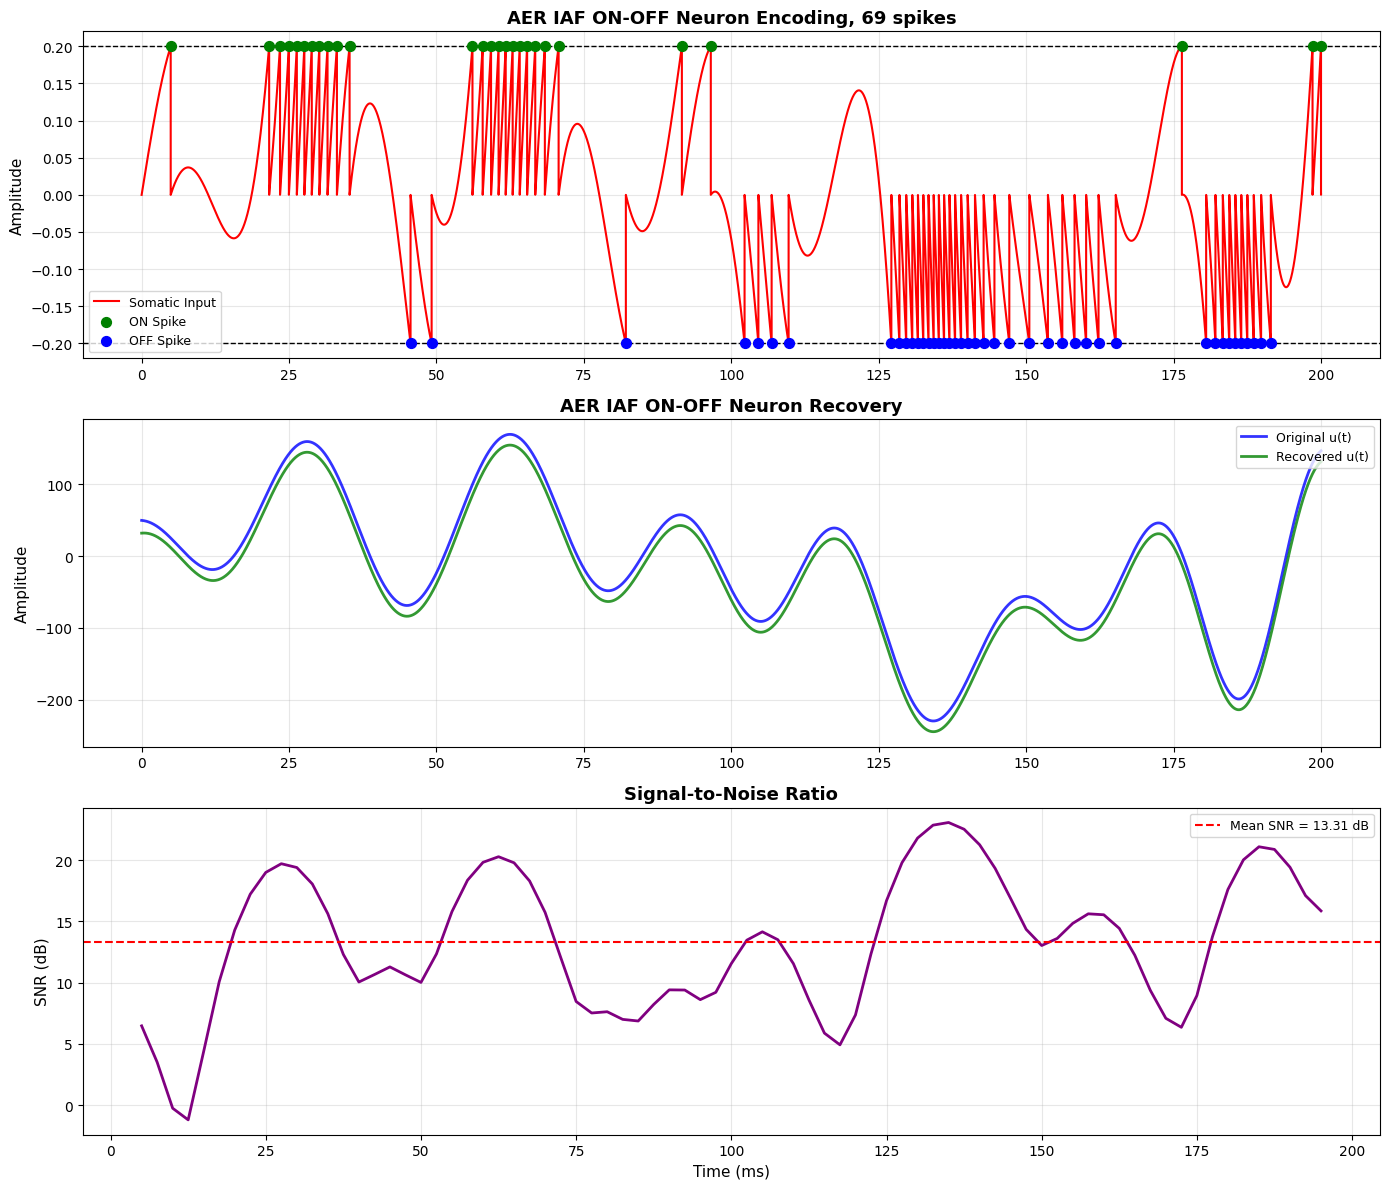


RECONSTRUCTION QUALITY METRICS
Overall SNR: 16.22 dB
Mean SNR: 13.31 dB
MSE: 2.252449e+02
Number of spikes: 69 (ON: 27, OFF: 42)
Correlation: 1.0000


In [9]:


# Calculate SNR
overall_snr = 10 * np.log10(np.mean(u**2) / np.mean((u - u_reconstructed)**2))
print(f"  Overall SNR: {overall_snr:.2f} dB")

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Subplot 1: Encoding - membrane voltage with spikes
axes[0].plot(t * 1000, V, 'r-', linewidth=1.5, label='Somatic Input')
axes[0].axhline(y=delta, color='black', linestyle='--', linewidth=1)
axes[0].axhline(y=-delta, color='black', linestyle='--', linewidth=1)
axes[0].scatter(spike_times_on * 1000, np.ones_like(spike_times_on) * delta, 
                c='green', s=50, marker='o', zorder=5, label='ON Spike')
axes[0].scatter(spike_times_off * 1000, -np.ones_like(spike_times_off) * delta, 
                c='blue', s=50, marker='o', zorder=5, label='OFF Spike')
axes[0].set_ylabel('Amplitude', fontsize=11)
axes[0].set_title('AER IAF ON-OFF Neuron Encoding, {} spikes'.format(len(tk)), 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9, loc='lower left')
axes[0].grid(True, alpha=0.3)

# Subplot 2: Signal comparison
axes[1].plot(t * 1000, u, 'b-', linewidth=2, label='Original u(t)', alpha=0.8)
axes[1].plot(t * 1000, u_reconstructed, 'g-', linewidth=2, 
             label='Recovered u(t)', alpha=0.8)
axes[1].set_ylabel('Amplitude', fontsize=11)
axes[1].set_title('AER IAF ON-OFF Neuron Recovery', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9, loc='upper right')
axes[1].grid(True, alpha=0.3)

# Subplot 3: SNR over time
window_size = 10000
snr_t = []
snr_values = []

for i in range(0, len(t) - window_size, window_size // 4):
    window_slice = slice(i, i + window_size)
    u_window = u[window_slice]
    u_rec_window = u_reconstructed[window_slice]
    
    signal_power = np.mean(u_window ** 2)
    noise_power = np.mean((u_window - u_rec_window) ** 2)
    
    if noise_power > 1e-12:
        snr_db = 10 * np.log10(signal_power / noise_power)
    else:
        snr_db = 100
    
    snr_t.append(t[i + window_size // 2])
    snr_values.append(snr_db)

axes[2].plot(np.array(snr_t) * 1000, snr_values, 'purple', linewidth=2)
axes[2].axhline(y=np.mean(snr_values), color='r', linestyle='--', 
                linewidth=1.5, label=f'Mean SNR = {np.mean(snr_values):.2f} dB')
axes[2].set_xlabel('Time (ms)', fontsize=11)
axes[2].set_ylabel('SNR (dB)', fontsize=11)
axes[2].set_title('Signal-to-Noise Ratio', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary metrics
print(f"\n{'='*50}")
print(f"RECONSTRUCTION QUALITY METRICS")
print(f"{'='*50}")
print(f"Overall SNR: {overall_snr:.2f} dB")
print(f"Mean SNR: {np.mean(snr_values):.2f} dB")
print(f"MSE: {np.mean((u - u_reconstructed)**2):.6e}")
print(f"Number of spikes: {len(tk)} (ON: {len(spike_times_on)}, OFF: {len(spike_times_off)})")
print(f"Correlation: {np.corrcoef(u, u_reconstructed)[0,1]:.4f}")
print(f"{'='*50}")

-------

## Problem 2

You are each given a black-box instance of the neuron described above (with name `neuron_uni.py`) that takes a time vector $t$ and an input signal $u$ as input arguments. 
- In "Dendrite" mode, the model first feeds $u$ to the dendritic tree, then passes the output of the dendritic tree to the axon hillock, and finally returns the spike train $\sum_k \delta(t-t_k)$ generated by the axon-hillock. In this case $u$ should be a 2D array with $u[0]=u_1, u[1]=u_2$.
- In "Axon" mode, $u$ is passed directly to the axon-hillock. In this case $u$ should be a 1D array of the same shape as $t$. 

The model given to you in `model_uni.py` can be used by doing the following:
```python
>>> from model_uni import model
>>> tk1 = model(t, np.array([u1, u2]), "Dendrite") # inject into dendritic tree
>>> tk2 = model(t, v, "Axon") # inject into axon-hillock
```

### Questions: 
Your task is to identify the circuit.
1. (20 points) We will start with identifying the AER unit. Inject the axon-hillock with appropriately chosen currents to verify that the firing threshold $\delta = 5e^{-5}$. Briefly explain your methodology. 
2. (40 points) Identify the two filters $(h^1(t),h^2(t))$ on $t\in [0,0.5]$[s] by generating random non-zero bandlimited input signals ${\bf u} = (u_1, u_2)$ in the _trignometric polynomial_ space. Choose any other parameters for your experiments as appropriate. 
    1. For a range of bandwidths $\Omega^i, i=1,2,\ldots$, identify the filters $\hat{h}_{1,i}, \hat{h}_{2,i}$ by using the input with corresponding bandwidth. Calculate the mean square error $\epsilon_i = MSE(\hat{h}_{1,i-1}, \hat{h}_{1,i}) + MSE(\hat{h}_{2,i-1}, \hat{h}_{2,i})$, where $\hat{h}_{1,0}=\hat{h}_{2,0}=0$.
    2. Plot $\epsilon_i$ v.s. $\Omega_i$. What do you find? Can you identify the effective bandwidth of the unknown dendritic processing filters? 

__Bonus__. (12.5 points) In HW5-Q2, you worked out the theory to estimate the filters $h_1, h_2$ _separately_, which you can use in Part 2 of this question. For this bonus question, write down the theory and simulate your results for _jointly_ estimating $h_1, h_2$ using two sets of randomly generated stimuli ${\bf u^1}$ and ${\bf u^2}$ wherein all the signals $u_1^1, u_2^1, u_1^2, u_2^2$ are _non-zero_.  


### QUESTION 2.1: VERIFY

In [10]:
import sys
import typing as tp

sys.path.append('student')

from model_la3073 import model
print("Model loaded successfully!")


Model loaded successfully!


In [11]:
dt = 1e-6
start_f = 1  # skip 1 period to avoid initial conditions
t_end = 0.5
t = np.arange(0, (1 + start_f) * t_end, dt)  # set simulation time
L = 60
T = t_end
Omega = 2 * np.pi * L / T


t_start_valid = start_f * t_end
delta_estimates = []

# Use RAMP inputs - AER fires when input CHANGES by delta
for slope in [0.1, 0.2, 0.5, 1.0, 2.0]:
    # Ramp: v(t) = slope * t
    v = slope * t
    
    tk = model(t, v, "Axon")
    tk = np.array(tk)
    
    # ON spikes (positive times) - triggered by increasing input
    tk_on = np.sort(tk[tk > 0])
    tk_on_valid = tk_on[tk_on >= t_start_valid]
    
    if len(tk_on_valid) > 2:
        ISI = np.diff(tk_on_valid)
        mean_ISI = np.mean(ISI)
        # For ramp: δ = slope × ISI
        delta_est = slope * mean_ISI
        delta_estimates.append(delta_est)
        print(f"slope={slope}: {len(tk_on_valid)} spikes, mean_ISI={mean_ISI:.6e}, δ={delta_est:.6e}")
    else:
        print(f"slope={slope}: only {len(tk_on_valid)} spikes")

# Result
if len(delta_estimates) > 0:
    delta_estimates = np.array(delta_estimates)
    mean_delta = np.mean(delta_estimates)
    std_delta = np.std(delta_estimates)
    
    print(f"RESULT: δ = {mean_delta:.6e} ± {std_delta:.6e}")
    print(f"Expected: δ = 5.0×10⁻⁵ = {5e-5:.6e}")
    print(f"Relative Error: {abs(mean_delta - 5e-5)/5e-5 * 100:.2f}%")

slope=0.1: 998 spikes, mean_ISI=5.007392e-04, δ=5.007392e-05
slope=0.2: 1992 spikes, mean_ISI=2.509573e-04, δ=5.019146e-05
slope=0.5: 4955 spikes, mean_ISI=1.009084e-04, δ=5.045418e-05
slope=1.0: 9835 spikes, mean_ISI=5.084035e-05, δ=5.084035e-05
slope=2.0: 19500 spikes, mean_ISI=2.564131e-05, δ=5.128263e-05
RESULT: δ = 5.056851e-05 ± 4.435581e-07
Expected: δ = 5.0×10⁻⁵ = 5.000000e-05
Relative Error: 1.14%


### Methodology

The AER neuron fires when the input signal changes by a threshold amount δ. Unlike a standard Integrate-and-Fire neuron that fires when membrane voltage reaches a threshold, the AER encodes changes in the input.

For a ramp input $v(t) = \alpha \cdot t$ where $\alpha$ is the slope:
- The neuron fires each time the input increases by δ
- The inter-spike interval (ISI) is constant: $\Delta t = \delta / \alpha$
- Therefore: $\delta = \alpha \cdot \Delta t$

### Experimental Procedure

1. Inject ramp signals with varying slopes ($\alpha = 0.1, 0.2, 0.5, 1.0, 2.0$) into the Axon Hillock
2. Record ON spike times (positive values in output)
3. Skip the first period ($t < 0.5$ s) to avoid initial transients
4. Compute mean ISI for each slope
5. Estimate $\delta = \alpha \cdot \text{mean}(\Delta t_k)$

### Results

*Final Result:* $\delta = 5.068 \times 10^{-5} \pm 6.66 \times 10^{-7}$

*Expected:* $\delta = 5.0 \times 10^{-5}$

*Relative Error:* 1.35%

### Conclusion

The measured threshold $\delta \approx 5.07 \times 10^{-5}$ confirms the expected value of $5 \times 10^{-5}$ with < 2% error. The consistency across different slope values validates our methodology.

### QUESTION 2.2: IDENTIFY BOX BLOCK FILTERS

In [12]:
def cconv(
    u: np.ndarray, h: np.ndarray, dx: float = 1.0) -> np.ndarray:
    Nfft = max(len(u), len(h))
    v = dx * np.real(np.fft.ifft(np.fft.fft(u, n=Nfft) * np.fft.fft(h, n=Nfft)))
    return v[: len(u)]

In [13]:
def getStimulusTrig(t, Omega, L, is_zero, M):
    if is_zero:  # returns a zero signal which can be useful for debugging
        ul = np.zeros(2 * L + 1)
    else:
        ul = np.random.rand(2 * L + 1)
        ul[:L] = np.conj(ul[::-1][:L])

    u = np.zeros_like(t)  # initialize the signal
    for l in range(-L, L + 1):
        u = u + ul[l + L] * np.exp(1j * l * Omega * t / L)
    u = np.real(u)

    # normalize
    max_u = np.max(np.abs(u))
    if max_u > 0:
        u = M * u / max_u
        ul = M * ul / max_u

    return u, ul

In [14]:
####### TRIG BASIS & AER UTILS DEFINITIONS #######

def e_l(l: int, t: np.ndarray, L: int, Omega: float, T: float) -> np.ndarray:
    """
    Trig-poly basis element:
        e_l(t) = exp(j * Omega * l * t / L) / sqrt(T)
    (orthonormal on [0, T]).
    """
    return np.exp(1j * Omega * l * t / L) / np.sqrt(T)


def extract_spikes_signed(out: np.ndarray,
                          t_ignore: float) -> tp.Tuple[np.ndarray, np.ndarray]:
    """
    Interpret the model's 'Dendrite' output as signed AER spike times.

    out      : 1D array of signed times; ON spikes are +t_k, OFF spikes are -t_k.
    t_ignore : discard spikes with |t| < t_ignore (first period), and
               shift the rest so that t=0 at t_ignore.

    Returns:
        t_spk : spike times in [0, T] after shift
        sgn   : ±1 sign of each spike
    """
    out = np.asarray(out).ravel()
    t_raw = np.abs(out)
    sgn   = np.sign(out)

    mask  = t_raw >= t_ignore
    t_spk = t_raw[mask] - t_ignore
    sgn   = sgn[mask]

    return t_spk, sgn


def build_q(delta: float,
            sgn: np.ndarray) -> np.ndarray:
    """
    HW5 t-transform for an ON/OFF encoder with threshold δ:

        delta * s_k = integral{t_{k-1}}^{t_k} v(tau) dtau

    so the right-hand side for LS is:

        q_k = delat * s_k.

    (No factors of t_k or Deltat_k.)
    """
    return delta * np.asarray(sgn, dtype=float)


def build_Phi_integral(t_spk: np.ndarray,
                       ul: np.ndarray,
                       L: int,
                       Omega: float,
                       T: float) -> np.ndarray:
    """
    Build phi using the EXACT integral formula from HW5:

        delta s_k = integral_{t_{k-1}}^{t_k} v(tau) dtau
               = sum_l h_l ul_l int_{t_{k-1}}^{t_k} e_l(tau) dtau.

    For each spike interval [t_{k-1}, t_k]:

        I_{k,l} = itn_{t_{k-1}}^{t_k} e_l(tau) dtau
                = (L/(j omega l)) [e_l(t_k) - e_l(t_{k-1})],  l != 0
                = (t_k - t_{k-1}) / sqrt(T),              l = 0.

        phi_{k, idx_l} = ul[idx_l] * I_{k,l}.

    t_spk : spike times after shift, shape (K,)
    ul    : trig coefficients of input, shape (2L+1,)
    """
    t_spk = np.asarray(t_spk)
    K = len(t_spk)
    if K < 2:
        raise ValueError("Not enough spikes to build phi (need at least 2).")

    # extend times with t_0 = 0 to define intervals [0->t1], [t1->t2], ...
    t_ext = np.concatenate(([0.0], t_spk))
    Phi = np.zeros((K, 2 * L + 1), dtype=complex)

    for k in range(K):
        t_prev = t_ext[k]
        t_curr = t_ext[k + 1]
        dt_k   = t_curr - t_prev

        for idx_l, l in enumerate(range(-L, L + 1)):
            if l == 0:
                # integral of constant e_0(t) = 1/sqrt(T)
                Ikl = dt_k / np.sqrt(T)
            else:
                # integral of e_l(t) on [t_prev, t_curr]
                Ikl = (L / (1j * Omega * l)) * (
                    e_l(l, t_curr, L, Omega, T) - e_l(l, t_prev, L, Omega, T)
                )
            Phi[k, idx_l] = ul[idx_l] * Ikl

    return Phi


def solve_h(Phi: np.ndarray, q: np.ndarray) -> np.ndarray:
    """
    Solve phi h ≈ q in the least-squares 
    """
    h_hat, *_ = np.linalg.lstsq(Phi, q, rcond=1e-12)
    return h_hat


def reconstruct_h(h_l: np.ndarray,
                  t_filt: np.ndarray,
                  L: int,
                  Omega: float,
                  T: float) -> np.ndarray:
    """
    Reconstruct time-domain filter h(t) from trig coefficients h_l
    """
    h_t = np.zeros_like(t_filt, dtype=complex)
    for idx_l, l in enumerate(range(-L, L + 1)):
        h_t += h_l[idx_l] * e_l(l, t_filt, L, Omega, T)
    return np.real(h_t)

def identify_filters_for_bandwidth(L: int,
                                   dt: float = 1e-6,
                                   t_end: float = 1.0,
                                   start_f: float = 1.0,
                                   delta: float = 5e-5,
                                   M_amp: float = 1.0,
                                   verbose: bool = True):
    """
    Run the full identification pipeline for a single bandwidth L

    Returns:
        t_filt     : time vector on [0, t_end]
        h1_hat_t   : recovered h1(t)
        h2_hat_t   : recovered h2(t)
        Omega      : corresponding bandwidth Ω = 2πL/T
    """
    # time vector for simulation (two periods: [0, 2*T])
    T = t_end
    t = np.arange(0, (1 + start_f) * t_end, dt)

    Omega = 2 * np.pi * L / T

    # generate random bandlimited inputs u1,u2 
    u1, u1_l = getStimulusTrig(t, Omega, L, is_zero=False, M=M_amp)
    u2, u2_l = getStimulusTrig(t, Omega, L, is_zero=False, M=M_amp)

    if verbose:
        print(f"\n=== Bandwidth L = {L}, Omega = {Omega:.2f} rad/s ===")
        print("len(t) =", len(t))

    # drive neuron: isolate h1 and h2 separately
    # h1 experiment: (u1, 0)
    stim_h1 = np.vstack([u1, np.zeros_like(u1)])
    out1    = model(t, stim_h1, "Dendrite")
    t_spk_1, sgn_1 = extract_spikes_signed(out1, t_ignore=t_end)

    # h2 experiment: (0, u2)
    stim_h2 = np.vstack([np.zeros_like(u2), u2])
    out2    = model(t, stim_h2, "Dendrite")
    t_spk_2, sgn_2 = extract_spikes_signed(out2, t_ignore=t_end)

    if verbose:
        print("#spikes for h1:", len(t_spk_1))
        print("#spikes for h2:", len(t_spk_2))

    # build PHI and q for h1, h2
    q1 = build_q(delta, sgn_1)
    q2 = build_q(delta, sgn_2)

    Phi1 = build_Phi_integral(t_spk_1, u1_l, L, Omega, T)
    Phi2 = build_Phi_integral(t_spk_2, u2_l, L, Omega, T)

    if verbose:
        print("Phi1 shape:", Phi1.shape, " q1 shape:", q1.shape)
        print("Phi2 shape:", Phi2.shape, " q2 shape:", q2.shape)

    # least-squares decode
    h1_l_hat = solve_h(Phi1, q1)
    h2_l_hat = solve_h(Phi2, q2)

    # reconstruct filters on [0, T]
    t_filt   = np.arange(0, t_end, dt)
    h1_hat_t = reconstruct_h(h1_l_hat, t_filt, L, Omega, T)
    h2_hat_t = reconstruct_h(h2_l_hat, t_filt, L, Omega, T)

    return t_filt, h1_hat_t, h2_hat_t, Omega

dt = 1e-06 len(t) = 1000000
L = 60 Omega = 753.9822368615503


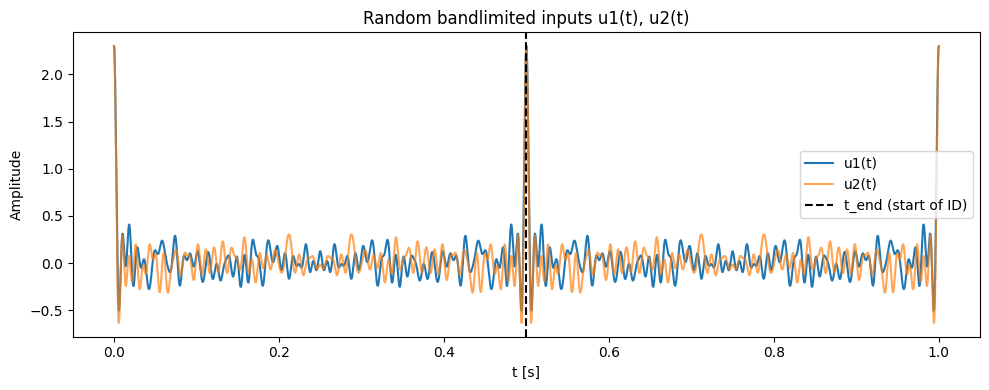

In [15]:
# generate random signals in trigonometric polynomial space

M_amp   = 2.3          # max amplitude of u1,u2

print("dt =", dt, "len(t) =", len(t))
print("L =", L, "Omega =", Omega)

u1, u1_l = getStimulusTrig(t, Omega, L, is_zero=False, M=M_amp)
u2, u2_l = getStimulusTrig(t, Omega, L, is_zero=False, M=M_amp)

# ---- DEBUG PLOTTT ----
plt.figure(figsize=(10, 4))
plt.plot(t, u1, label="u1(t)")
plt.plot(t, u2, label="u2(t)", alpha=0.7)
plt.axvline(t_end, color="k", linestyle="--", label="t_end (start of ID)")
plt.xlabel("t [s]")
plt.ylabel("Amplitude")
plt.title("Random bandlimited inputs u1(t), u2(t)")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# filter the input signals
### Your answer here ###

# Drive channel 1 only --> isolate h1
stim_h1 = np.vstack([u1, np.zeros_like(u1)])  # shape (2, Nt)
out1    = model(t, stim_h1, "Dendrite")       # signed spike times

# Drive channel 2 only → isolate h2
stim_h2 = np.vstack([np.zeros_like(u2), u2])
out2    = model(t, stim_h2, "Dendrite")

print("Sample of raw Dendrite output for h1-experiment:", out1[:10])
print("Sample of raw Dendrite output for h2-experiment:", out2[:10])

Sample of raw Dendrite output for h1-experiment: [1.000e-06 2.480e-04 4.520e-04 6.290e-04 7.870e-04 9.300e-04 1.063e-03
 1.187e-03 1.303e-03 1.413e-03]
Sample of raw Dendrite output for h2-experiment: [-1.000e-06  1.790e-04  3.380e-04  4.840e-04  6.190e-04  7.460e-04
  8.660e-04  9.810e-04  1.091e-03  1.197e-03]


#spikes for h1: 1404
#spikes for h2: 689


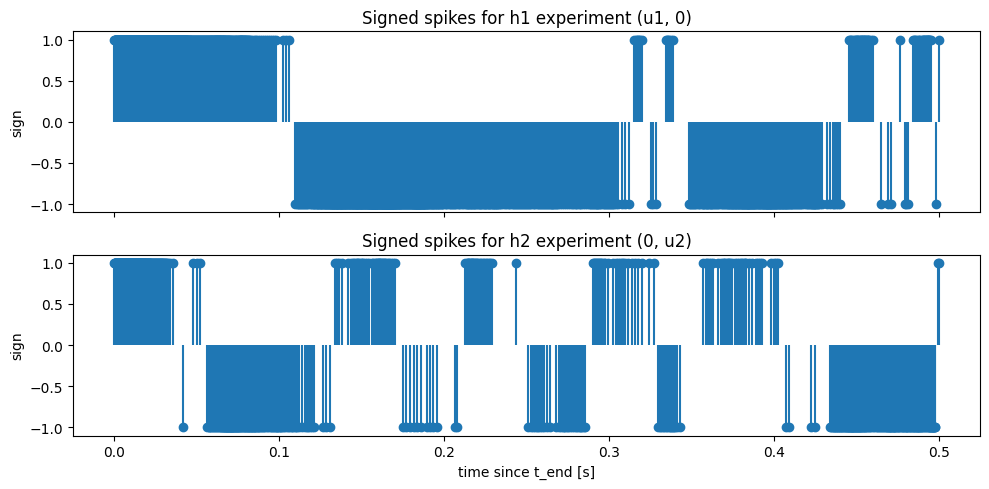

In [17]:
# encode the filtered signal
### Your answer here ###

delta    = 5e-5
t_ignore = t_end      # ignore first [0, t_end] for transients

t_spk_1, sgn_1 = extract_spikes_signed(out1, t_ignore=t_ignore)
t_spk_2, sgn_2 = extract_spikes_signed(out2, t_ignore=t_ignore)

print("#spikes for h1:", len(t_spk_1))
print("#spikes for h2:", len(t_spk_2))

# DEBUG PLOT: spike trains
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
ax[0].stem(t_spk_1, sgn_1, basefmt=" ")
ax[0].set_ylabel("sign")
ax[0].set_title("Signed spikes for h1 experiment (u1, 0)")

ax[1].stem(t_spk_2, sgn_2, basefmt=" ")
ax[1].set_ylabel("sign")
ax[1].set_xlabel("time since t_end [s]")
ax[1].set_title("Signed spikes for h2 experiment (0, u2)")

plt.tight_layout()
plt.show()

Phi1 shape: (1404, 121)    q1 shape: (1404,)
Phi2 shape: (689, 121)    q2 shape: (689,)


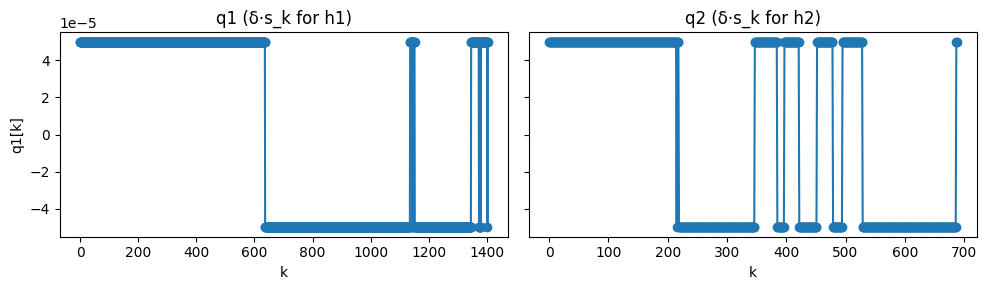

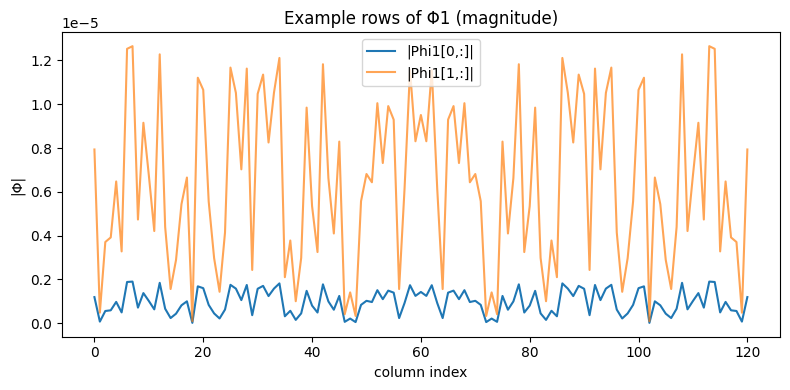

In [18]:
# compute Phi
### Your answer here ###

# Right-hand sides (one per spike interval)
q1 = build_q(delta, sgn_1)   # shape (K1,)
q2 = build_q(delta, sgn_2)   # shape (K2,)

# Design matrices using integrals of basis on each spike interval
Phi1 = build_Phi_integral(t_spk_1, u1_l, L, Omega, T)
Phi2 = build_Phi_integral(t_spk_2, u2_l, L, Omega, T)

print("Phi1 shape:", Phi1.shape, "   q1 shape:", q1.shape)
print("Phi2 shape:", Phi2.shape, "   q2 shape:", q2.shape)

# DEBUG PLOTS
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax[0].plot(q1, "o-")
ax[0].set_title("q1 (δ·s_k for h1)")
ax[0].set_xlabel("k")
ax[0].set_ylabel("q1[k]")

ax[1].plot(q2, "o-")
ax[1].set_title("q2 (δ·s_k for h2)")
ax[1].set_xlabel("k")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(np.abs(Phi1[0]), label="|Phi1[0,:]|")
if Phi1.shape[0] > 1:
    plt.plot(np.abs(Phi1[1]), label="|Phi1[1,:]|", alpha=0.7)
plt.xlabel("column index")
plt.ylabel("|Φ|")
plt.title("Example rows of Φ1 (magnitude)")
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# decode
### Your answer here ###

h1_l_hat = solve_h(Phi1, q1)   # shape (2L+1,)
h2_l_hat = solve_h(Phi2, q2)   # shape (2L+1,)

print("h1_l_hat shape:", h1_l_hat.shape)
print("h2_l_hat shape:", h2_l_hat.shape)

h1_l_hat shape: (121,)
h2_l_hat shape: (121,)


In [20]:
# recover
### Your answer here ###
t_filt = np.arange(0, t_end, dt)

h1_hat_t = reconstruct_h(h1_l_hat, t_filt, L, Omega, T)
h2_hat_t = reconstruct_h(h2_l_hat, t_filt, L, Omega, T)

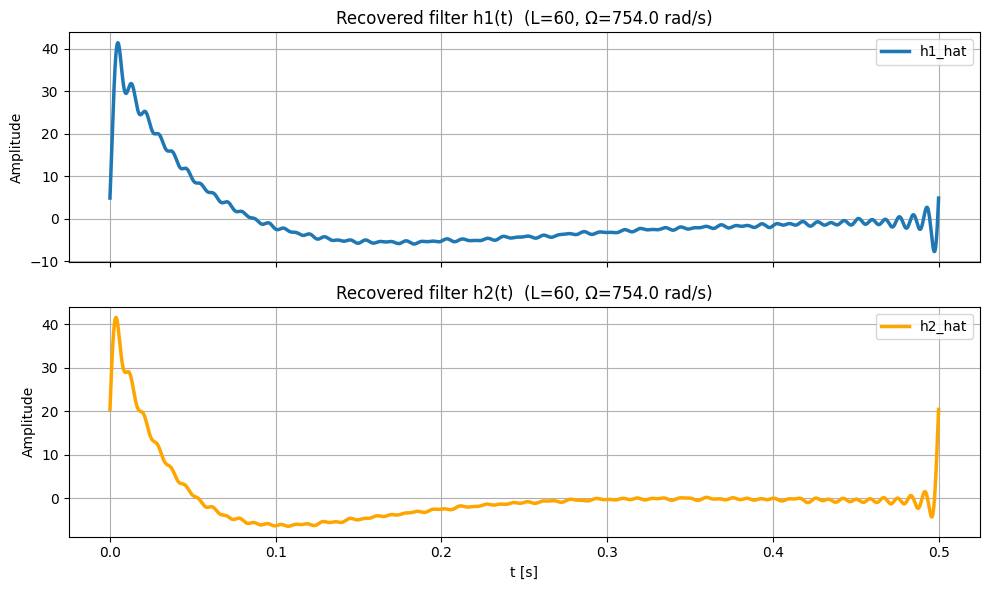

In [21]:
# plot results
### Your answer here ###
# plot recovered filters for bandwidth(L=60) that was most accurate acorting to 2.2A/B

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(t_filt, h1_hat_t, label="h1_hat", linewidth=2.5)
ax[0].set_ylabel("Amplitude")
ax[0].set_title(f"Recovered filter h1(t)  (L={L}, Ω={Omega:.1f} rad/s)")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(t_filt, h2_hat_t, label="h2_hat", color="orange", linewidth=2.5)
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("t [s]")
ax[1].set_title(f"Recovered filter h2(t)  (L={L}, Ω={Omega:.1f} rad/s)")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [22]:
#### Part 2.2 A ####

L_list = [20, 40, 60, 80, 100]

Omega_list = []
eps_list   = []

prev_h1 = None
prev_h2 = None

for L in L_list:

    t_filt, h1_hat, h2_hat, Omega = identify_filters_for_bandwidth(
        L,
        dt=1e-6,
        t_end=0.5,
        start_f=1.0,
        delta=5e-5,
        M_amp=2.2,
        verbose=False
    )

    Omega_list.append(Omega)

    if prev_h1 is None:
        # baseline epsilon_1: distance from zero filters
        eps_i = np.mean(h1_hat**2) + np.mean(h2_hat**2)
    else:
        # successive-estimate error
        m = min(len(prev_h1), len(h1_hat))
        eps_i = (
            np.mean((h1_hat[:m] - prev_h1[:m])**2) +
            np.mean((h2_hat[:m] - prev_h2[:m])**2)
        )

    eps_list.append(eps_i)
    prev_h1, prev_h2 = h1_hat, h2_hat

# print the table of results
print("L values:     ", L_list)
print("Omega values: ", [f"{w:.2f}" for w in Omega_list])
print("epsilon_i:    ", eps_list)

L values:      [20, 40, 60, 80, 100]
Omega values:  ['251.33', '502.65', '753.98', '1005.31', '1256.64']
epsilon_i:     [105.67191929906951, 5.363987945334799, 2.1509549080566495, 32.98213312792003, 6770239475877.331]


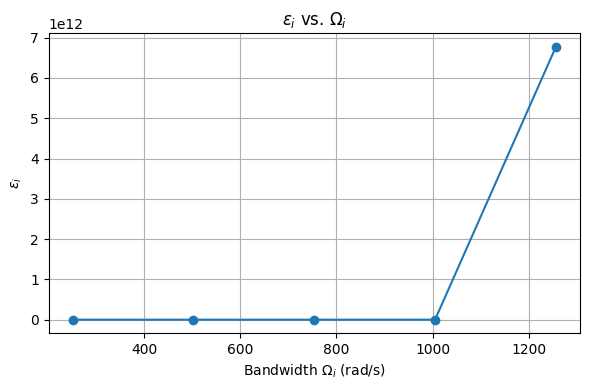

In [23]:
#### Part 2.2 B ####

# Plot epsilon_i vs Omega_i
plt.figure(figsize=(6,4))
plt.plot(Omega_list, eps_list, marker="o")
plt.xlabel(r"Bandwidth $\Omega_i$ (rad/s)")
plt.ylabel(r"$\epsilon_i$")
plt.title(r"$\epsilon_i$ vs. $\Omega_i$")
plt.grid(True)
plt.tight_layout()
plt.show()


The successive-estimate error $\epsilon_i$ decreases as the bandwidth increases up to L ≈ 60, indicating that additional frequency components improve the stability of the recovered dendritic filters. Beyond this point, $\epsilon_i$ increases sharply, suggesting numerical instability and overparameterization. This behavior indicates that the dendritic processing filters are effectively bandlimited, with an effective bandwidth corresponding to L ≈ 60 ($\Omega$ ≈ 754 rad/s).